# Text-to-SQL Query Generator Using Mistral Nemo 12B and Amazon SageMaker

## Introduction
This notebook demonstrates how to build a tool that converts plain English questions into SQL queries. Follow the steps below to see how we use the Mistral Nemo 12B language model, Amazon SageMaker, and other additional AWS services to help with the text-to-SQL conversion.  


## Dataset
The notebook uses an [Online Retail Transaction Dataset](https://archive.ics.uci.edu/dataset/352/online+retail) from a UK-based online retailer. The dataset includes:

- Over 500,000 transactions from 2010-2011
- Customer purchase records with product details, quantities and prices
- International transactions across multiple countries
- Detailed invoice and stock information

The dataset is stored in Amazon S3 and made queryable through Amazon Athena's serverless SQL engine for efficient data analysis.



## Architecture


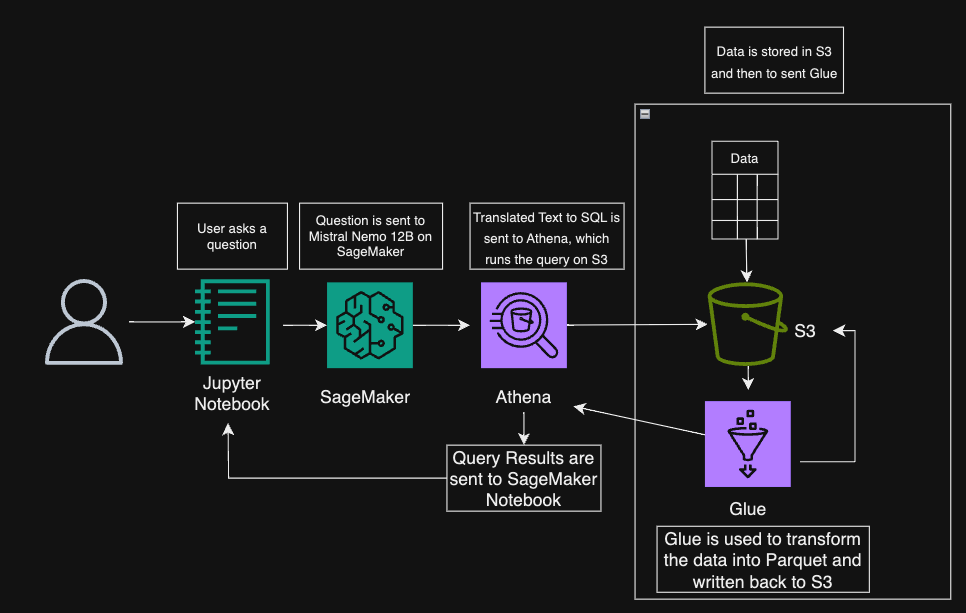

## AWS Services Used  

Here's a list of the main AWS services we'll be using:


**[Amazon S3 (Simple Storage Service)](https://aws.amazon.com/s3/)**
- Provides highly durable, secure object storage with 99.999999999% durability 
- Cost-effective with multiple storage tiers
- Storage location for Athena query results

**[AWS Glue](https://aws.amazon.com/glue/)**
- Serverless ETL service for data preparation
- Converts raw data into optimized Parquet format
- Manages data catalog and schema definitions
- Enables seamless data discovery and querying

**[Amazon Athena](https://aws.amazon.com/athena/)**
- Serverless interactive query service
- Analyzes data directly in S3 using standard SQL
- Pay-per-query pricing model
- Integrates with AWS Glue catalog

**[Amazon SageMaker](https://aws.amazon.com/sagemaker/)**
- Fully managed ML service for model deployment
- Hosts and serves the Mistral Nemo 12B language model
- Provides auto-scaling and high availability
- Handles the real-time natural language processing requests  

## Prerequisites

1. **AWS Account Setup**
   - Active AWS account with appropriate IAM permissions
   - Basic familiarity with AWS console navigation

2. **Data Preparation**
   - [The dataset](https://archive.ics.uci.edu/dataset/352/online+retail) converted to Apache Parquet format in Amazon S3
   - Follow the [AWS Glue ETL guide](https://docs.aws.amazon.com/prescriptive-guidance/latest/patterns/three-aws-glue-etl-job-types-for-converting-data-to-apache-parquet.html) for step-by-step data transformation instructions
   - Ensure proper S3 bucket permissions are configured

3. **AWS Glue Configuration** 
   - AWS Glue Data Catalog properly configured and populated
   - Athena integration enabled following the [official documentation](https://docs.aws.amazon.com/athena/latest/ug/data-sources-glue.html)
   - Verify table metadata and sample queries work as expected

4. **Model Deployment**
   - Mistral Nemo 12B model successfully deployed on Amazon SageMaker
   - Follow this [deployment notebook](https://github.com/aws-samples/mistral-on-aws/blob/main/notebooks/Mistral-Nemo-Instruct-2407_deploy_sample.ipynb) for detailed setup instructions
   - Confirm model endpoint is active and responding to inference requests
   - Monitor endpoint metrics and costs through CloudWatch

Note: Please ensure all prerequisites are completed and tested before proceeding with the main implementation.


## Setup Dependencies  
`boto3` is the official AWS SDK (Software Development Kit) for Python that provides programmatic access to AWS services and resources. It enables you to:
- Interact with AWS services like S3, EC2, SageMaker, Lambda, DynamoDB and more
- Create, configure and manage AWS resources 
- Build AWS-powered applications and automation workflows
- Handle authentication, request retries, and error handling


 The `json` library is a built-in Python module used for encoding and decoding JSON (JavaScript Object Notation) data. It is essential for:
- Parsing JSON responses returned by AWS services
- Converting Python dictionaries/objects to JSON strings for API requests 
- Serializing and deserializing data between Python and JSON formats


In [22]:
# Import required libraries
import boto3
import json

# AWS clients
AWS clients are used to interact with different AWS services:
- Athena client: Used to query data stored in S3 using SQL
- Glue client: Used for ETL (Extract, Transform, Load) jobs and data catalog management  
- SageMaker Runtime client: Used to invoke deployed machine learning model endpoints

In [23]:
athena_client = boto3.client('athena')     # For running SQL queries
glue_client = boto3.client('glue')         # For managing data catalogs
smr = boto3.client('sagemaker-runtime')    # For running Mistral Nemo 12B on SageMaker

# Helper functions for AWS Glue and Athena database operations

`get_table_schema`
- Takes a database name as input
- Uses AWS Glue Data Catalog API to retrieve metadata about all tables in the database
- Returns a dictionary containing table names and their column definitions

`format_schema_for_prompt`
- Takes the schema dictionary from get_table_schema
- Formats it into a human-readable string with table names and column details
- Used to prepare schema information for prompts and documentation

`execute_athena_query`
- Takes a SQL query string as input
- Executes the query using Amazon Athena service
- Stores query results in a specified S3 bucket location
- Returns query execution details and results location

IMPORTANT: Replace {INSERT-YOUR-S3-BUCKET} with your own S3 bucket name.  
The bucket will be used to store Athena query results.

In [24]:
def get_table_schema(database_name):
    tables = glue_client.get_tables(DatabaseName=database_name)['TableList']
    schema = {}
    for table in tables:
        table_name = table['Name']
        columns = table['StorageDescriptor']['Columns']
        schema[table_name] = [f"{col['Name']} ({col['Type']})" for col in columns]
    return schema

def format_schema_for_prompt(schema):
    formatted = "Database Schema:\n"
    for table, columns in schema.items():
        formatted += f"Table: {table}\n"
        formatted += "Columns:\n"
        for column in columns:
            formatted += f"- {column}\n"
        formatted += "\n"
    return formatted

def execute_athena_query(query, database):
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': 's3://{INSERT-YOUR-S3-BUCKET}/'  # Replace with your S3 bucket
        }
    )
    return response['QueryExecutionId']

# Configuration Variables for Athena Database and Endpoint Connections  

`database_name` is the name of the Athena database to query  

`endpoint_name` is the name of the SageMaker endpoint for model inference

These variables should be updated with your specific configuration values before running the code.

IMPORTANT: 
1. Replace {INSERT-ATHENA-DATABASE-NAME} with your own Athena Database Name.
2. Replace {INSERT-YOUR-SAGEMAKER-ENDPOINT-NAME} with your own SageMaker endpoint name.  


In [25]:
# Set up variables
database_name = "{INSERT-ATHENA-DATABASE-NAME}"  # Replace with your Athena database name
endpoint_name = "{INSERT-YOUR-SAGEMAKER-ENDPOINT-NAME}"  # Replace with your SageMaker endpoint name

# Get the schema and prepare the prompt
This section prepares the prompt for generating SQL queries
1. Retrieves the database schema using get_table_schema()
2. Formats the schema into a prompt-friendly format
3. Takes a user query as input
4. Constructs the final prompt that will be sent to the model

IMPORTANT: 
Replace {INSERT-YOUR-QUESTION} with your own question.

In [26]:
# Get the schema and prepare the prompt
schema = get_table_schema(database_name)
schema_prompt = format_schema_for_prompt(schema)

user_query = "{INSERT-YOUR-QUESTION}" # Enter Your question
prompt = f"""Given the following Athena database schema:

{schema_prompt}

Generate a SQL query to answer the following question: {user_query}

The SQL query should be valid for Athena and use only the tables and columns provided in the schema.
Return only the SQL query, without any explanations or additional text."""

# Invoke SageMaker endpoint
body = {
    "inputs": f"<s> [INST]{prompt}[/INST]",
    "parameters": {
        "max_new_tokens": 3000,
        "return_full_text": False,
        "temperature": 0.1,
        "top_p": 0.9,
        "top_k": 50,
    }
}

resp = smr.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(body)
)

# Process the response and generate SQL
response_body = json.loads(resp['Body'].read().decode())
generated_sql = response_body[0]['generated_text'].strip()

print("Generated SQL:")
print(generated_sql)


Generated SQL:
SELECT description, SUM(quantity) as total_quantity
FROM etl_aws_text_to_sql_iad
GROUP BY description
ORDER BY total_quantity DESC
LIMIT 1;


# Execute the query against the specified Athena database
This function submits a SQL query to Athena and returns:

- query_execution_id: A unique identifier for tracking the query execution
- If the query fails to execute, an Exception will be raised with error details  


In [27]:
try:
    query_execution_id = execute_athena_query(generated_sql, database_name)
    print(f"Query execution started. Execution ID: {query_execution_id}")
except Exception as e:
    print(f"Error executing query: {str(e)}")
    print("Please review and modify the generated SQL before execution.")

Query execution started. Execution ID: 7180bca8-7ddf-4787-8f7d-3ec5fbe62364


# Check query execution status
Athena queries run asynchronously, meaning they continue executing in the background.
You can run this cell repeatedly to monitor the progress of your query.

Common statuses include:
- QUEUED: Query is waiting to begin execution
- RUNNING: Query is actively executing
- SUCCEEDED: Query completed successfully
- FAILED: Query encountered an error  


Note: This cell can be run multiple times to check the status.


In [28]:
def get_query_execution_status(query_execution_id):
    response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    return response['QueryExecution']['Status']['State']
status = get_query_execution_status(query_execution_id)
print(f"Query status: {status}")

Query status: SUCCEEDED


# Get the query results
Note: Only run this cell after the query has completed successfully, otherwise you may get timeout errors or incomplete results.

Prerequisites:
- An Athena query must have been executed and completed successfully
- The query execution ID must be available

In [29]:
def get_query_results(query_execution_id):
    response = athena_client.get_query_results(QueryExecutionId=query_execution_id)
    return response['ResultSet']['Rows']
results = get_query_results(query_execution_id)
for row in results:
    print(row)

{'Data': [{'VarCharValue': 'description'}, {'VarCharValue': 'total_quantity'}]}
{'Data': [{'VarCharValue': 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'}, {'VarCharValue': '53847'}]}


# Explain the Query Results  

Let's now use Mistral Nemo 12B to generate an explaination of the query results.

In [30]:
def explain_results(results, user_query, generated_sql):
    print("Query Analysis and Results Explanation")
    print("=====================================")
    print(f"Original Question: {user_query}")
    print(f"\nGenerated SQL Query:\n{generated_sql}")
    print("\nResults Interpretation:")
    
    # Skip the header row and process results
    if len(results) > 1:  # Check if we have results beyond the header
        header = [field['VarCharValue'] for field in results[0]['Data']]
        data = []
        for row in results[1:]:  # Skip header row
            data.append([field['VarCharValue'] for field in row['Data']])
            
        print("\nFound Results:")
        for row in data:
            # For the specific "top selling product" query, use this context otherwise use
            if "description" in header and "total_quantity" in header:
                desc_index = header.index("description")
                qty_index = header.index("total_quantity")
                print(f"Product: {row[desc_index]}")
                print(f"Total Quantity Sold: {row[qty_index]}")
            else:
                # Generic result display
                for i, value in enumerate(row):
                    print(f"{header[i]}: {value}")
    else:
        print("No results found for this query.")
    
    print("\nNote: Results are based on the available data in the Athena database.")

# Example usage:
explain_results(results, user_query, generated_sql)


Query Analysis and Results Explanation
Original Question: What is the top selling product?

Generated SQL Query:
SELECT description, SUM(quantity) as total_quantity
FROM etl_aws_text_to_sql_iad
GROUP BY description
ORDER BY total_quantity DESC
LIMIT 1;

Results Interpretation:

Found Results:
Product: WORLD WAR 2 GLIDERS ASSTD DESIGNS
Total Quantity Sold: 53847

Note: Results are based on the available data in the Athena database.


## Troubleshooting Tips

Common Issues:
1. "Access Denied" errors
   - Check your AWS credentials
   - Verify IAM permissions  

     
2. "Endpoint not found" errors
   - Ensure your SageMaker endpoint is running
   - Check the endpoint name  


3. "Database not found" errors
   - Verify your Athena database name
   - Check if tables are properly created  
   
     

## License
This project uses [Mistral Nemo 12B model](https://huggingface.co/nvidia/Mistral-NeMo-12B-Instruct) under the Apache 2.0 license.  
The [Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail) uses the Creative Commons Attribution 4.0 International (CC BY 4.0) license.